In [46]:
import sys
import time

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt

In [47]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3
log_interval = 10

In [48]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [49]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.flatten = nn.Linear(32, 2)
        self.reshape = nn.Linear(2, 32)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )
    def encode(self, x):
        x = self.encoder(x).view(-1, 32)
        return torch.tanh(self.flatten(x))
    def decode(self, x):
        x = self.reshape(x).view(-1, 8, 2, 2)
        return self.decoder(x)
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [50]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [51]:
for epoch in range(num_epochs):
    b_count = 0
    s = ''
    start = time.time()
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        b_count += len(img)
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        s = 'Train Epoch: {:3d} [{:6d}/{:6d} ({:3.0f}%)    Loss: {:5.4f}'
        s = s.format(epoch, b_count, len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item())
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    t = time.time() - start
    sys.stdout.write('{0}    Time {1:3.2f}s\n'.format(s, t))

Train Epoch:   0 [ 60000/ 60000 (100%)    Loss: 0.0597    Time 7.00s
Train Epoch:   1 [ 60000/ 60000 (100%)    Loss: 0.0578    Time 6.66s
Train Epoch:   2 [ 60000/ 60000 (100%)    Loss: 0.0576    Time 6.73s
Train Epoch:   3 [ 60000/ 60000 (100%)    Loss: 0.0559    Time 6.88s
Train Epoch:   4 [ 60000/ 60000 (100%)    Loss: 0.0567    Time 6.90s
Train Epoch:   5 [ 60000/ 60000 (100%)    Loss: 0.0515    Time 6.86s
Train Epoch:   6 [ 60000/ 60000 (100%)    Loss: 0.0558    Time 6.84s
Train Epoch:   7 [ 60000/ 60000 (100%)    Loss: 0.0516    Time 6.87s
Train Epoch:   8 [ 60000/ 60000 (100%)    Loss: 0.0545    Time 6.58s
Train Epoch:   9 [ 60000/ 60000 (100%)    Loss: 0.0515    Time 6.67s
Train Epoch:  10 [ 60000/ 60000 (100%)    Loss: 0.0508    Time 6.60s
Train Epoch:  11 [ 60000/ 60000 (100%)    Loss: 0.0509    Time 6.68s
Train Epoch:  12 [ 60000/ 60000 (100%)    Loss: 0.0508    Time 7.08s
Train Epoch:  13 [ 60000/ 60000 (100%)    Loss: 0.0508    Time 7.01s
Train Epoch:  14 [ 60000/ 60000 (1

KeyboardInterrupt: 

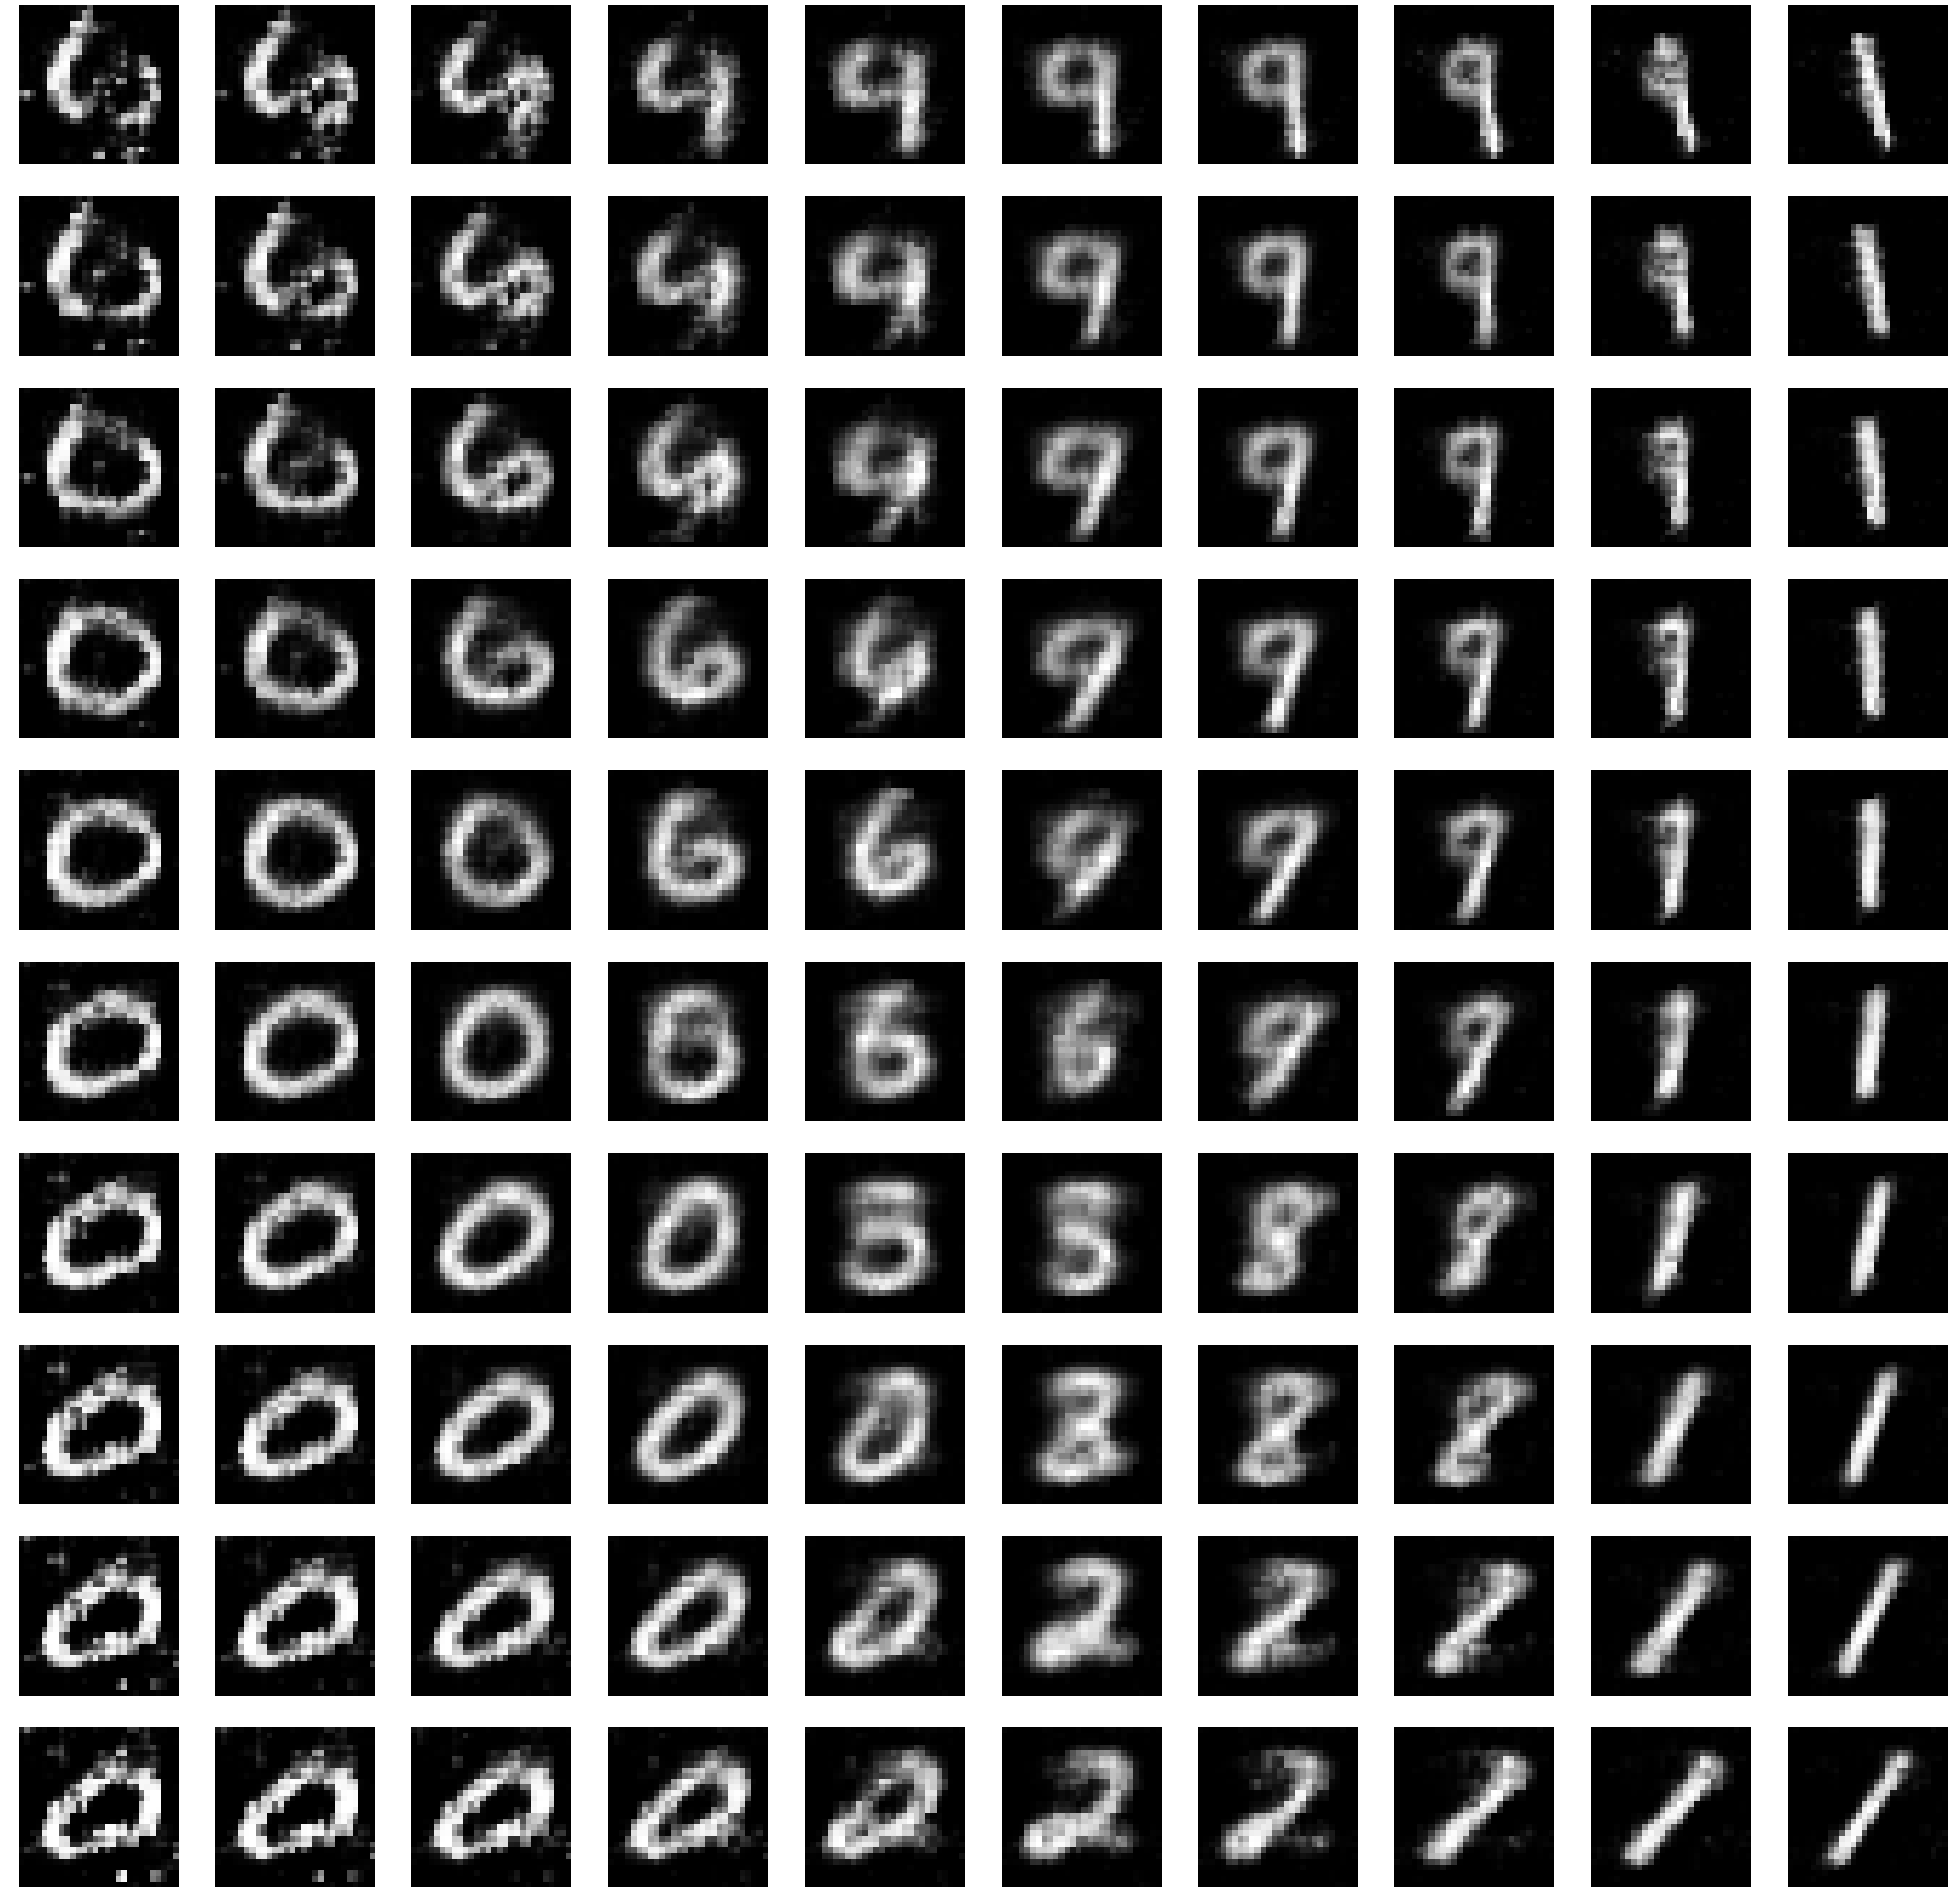

In [7]:
r = 10
nimg = r * 10
f, ax = plt.subplots(int(nimg/r), r, figsize=(r * 5, nimg * 5 / r))
for i in range(int(nimg/r)):
    for j in range(r):
        with torch.no_grad():
            e = torch.Tensor([-1 + j/5, -1 + i/5]).cuda()
            d = model.decode(e).cpu()[0][0]
        ax[i][j].imshow(d, cmap='gray')
        ax[i][j].axis('off')

In [52]:
from torchvision.models.resnet import BasicBlock, conv1x1

In [61]:
bl = nn.Sequential(
    BasicBlock( 1,  64, stride=2, downsample=nn.Sequential(conv1x1( 1,  64, 2), nn.BatchNorm2d(64))),
    BasicBlock(64, 128, stride=2, downsample=nn.Sequential(conv1x1(64, 128, 2), nn.BatchNorm2d(128))),
    )

In [62]:
sample = iter(dataloader).next()

In [63]:
bl(sample[0]).shape

torch.Size([128, 128, 7, 7])

In [59]:
sample[0].shape

torch.Size([128, 1, 28, 28])

In [60]:
torch.__version__

'1.1.0'